# 02. Нейросети и PyTorch

## План
1. Готовим обучение
    1. Данные: `Dataset` & `DataLoader` 
    2. Модель: `nn.Module`
    3. Рутина: все остальное
2. Учим
    1. Baseline
    2. Stack more layers
3. I/O


In [1]:
import torch

## 1. Готовим обучение 

Общий подход к решению задачи на pytorch такой:
1. Подготовить данные, реализовать (или использовать готовый) класс `Dataset`, наследуясь от `torch.utils.data.Dataset`, обернуть его в `torch.utils.data.DataLoader`.
2. Реализовать (или взять ±готовую) модель, наследуясь от `torch.nn.Module`.
3. Приготовить оптимизатор для весов модели (из `torch.optim` или свой) и лосс
4. Написать код для рутины обучения, включающий обработку данных из `DataLoader`, прогон их через модель, вычисление лосса и обновление весов оптимизатором.

### 1.1. Данные: `Dataset` & `DataLoader`

* [Tutorial @ pytorch.org](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Класс датасета предоставит нам интерфейс к данным:
* Метод `__getitem__(self, i)` позволяет получить `i`-й элемент обучающей выборки, обычно пару (data, label).
    * Также обязательным является определение метода `__len__(self)`.
* Можно сделать так, чтобы экземпляр класса датасета просто возвращал исходные данные, а можно (нужно) добавить в него аугментирование данных.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

`Dataset` - абстрактный класс, его нельзя использовать напрямую, а только через наследование:

In [3]:
dataset = Dataset()
dataset[0]

NotImplementedError: 

Создадим датасет поверх игрушечных данных с прошлого семинара:

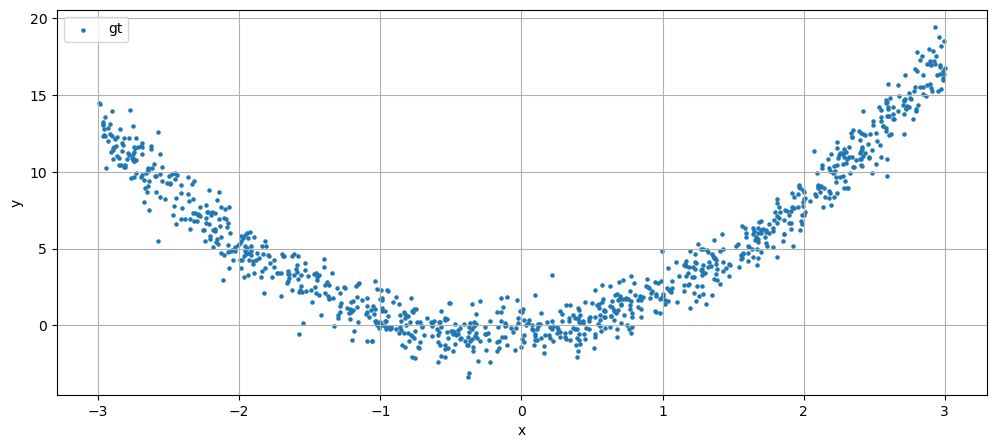

In [4]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 1000

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [5]:
class CustomDataset(Dataset):
    
    def __init__(self, xs, ys): # def __init__(self, train_path='/home/data/'):
        super().__init__()
        
        if len(xs) != len(ys):
            raise ValueError(f"lens mismatch: {len(xs)} != {len(ys)}")
            
        self.xs = xs
        self.ys = ys
        # self.train = load(train_path)
        # self.train_path = train_path
        
    def __len__(self):
        return len(self.xs)
        
    def __getitem__(self, i):
        # PIL.load(self.train_path + str(i) + '.png')
        return (self.xs[i], self.ys[i])
    
    # [dataset[0], dataset[1]]
    # tensor(4, 5), tensor(6, 5) 
    # padding = add padding_values to the end or to start
    # 1 2 3 4 0 0
    # tensor(6, 5), tensor(6, 5)
    @staticmethod
    def collate_fn(items_list):
        xs = torch.zeros(len(items_list), 1)
        ys = torch.zeros(len(items_list), 1)

        for i, (x, y) in enumerate(items_list):
            xs[i] = x
            ys[i] = y

        return (xs, ys) # (t_sent, t_sent_label, unt_sent, att_mask)

Метод `collate_fn` нужен не столько для самого датасета, сколько для оборачивания его в `DataLoader` - об этом чуть ниже.

In [6]:
dataset = CustomDataset(xs, ys)
dataset[0]

(1.712151502282615, 6.261151337822555)

In [7]:
dataset[1]

(1.6798548487128215, 6.005594456243541)

In [8]:
len(dataset), len(xs)

(1000, 1000)

In [11]:
dataset[100]

(0.34656497056469693, -0.9502726915332733)

По датасету можно итерироваться (но вам это вряд ли будет нужно часто):

In [84]:
for x in dataset:
    print(x)
    break

(1.712151502282615, 6.261151337822555)


Теоретически, для обучения достаточно уже объекта типа `Dataset`. Однако, для удобства и для автоматизации процессов перемешивания данных, формирования батчей и использования многопоточности есть удобный класс `DataLoader`:

In [9]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True, 
    collate_fn=dataset.collate_fn
)

"Длина" даталоадера - это количество батчей:

In [10]:
len(dataloader)

31

К даталоадеру нельзя обращаться по индексу, но можно итерироваться по нему:

In [11]:
dataloader[0]

TypeError: 'DataLoader' object is not subscriptable

In [88]:
for batch in dataloader:
    xs, ys = batch
    print(xs.shape, ys.shape)

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])


Как именно происходит сборка батчей, покажем, реализовав свой игрушечный даталоадер с аналогичным функционалом:

**Задание**:
Реализовать метод `__getitem__(self, i)`, который должен возвращать i-й батч. 
* Батч должен быть списком с числом элементов = равным числу элементов, возвращаемых датасетом при обращении по индексу (обычно 2 - данные и лейблы, но есть варианты).
    * Каждый из элементов содержит не отдельный объект, а склеенный из отдельных объектов тензов
    * Длина каждого = `batch_size`
* Для сборки батча из отдельных элементов датасета используйте метод `self.dataset.collate_fn`

In [89]:
class MyDataLoader:
    
    def __init__(self, dataset, batch_size, collate_fn):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn
        
        self.indices = np.arange(len(dataset))
        
    def __len__(self):
        return len(dataset) // self.batch_size
    
    def __getitem__(self, i):
        # YOUR CODE HERE
        
        left_border = self.batch_size*i
        right_border = min(self.batch_size*(i+1), len(self.indices))
        indices = self.indices[left_border:right_border]
        
        items = [self.dataset[idx] for idx in indices]

        batch = self.collate_fn(items)

        # indices = ...
        # items = ...
        # batch = ...
        
        # END OF YOUR CODE
        
        return batch
        

In [90]:
my_dataloader = MyDataLoader(dataset, batch_size=32, collate_fn=dataset.collate_fn)

In [91]:
batch = my_dataloader[0]

assert len(batch) == 2
assert batch[0].shape == (32, 1)
assert batch[1].shape == (32, 1)

### 1.2. Модель: `nn.Module`

Нейросетевые модели состоят из слоев, которые применяются ко входу (обычно) последовательно.
Каждый слой должен быть наследником `torch.nn.Module`, чтобы сам pytorch понимал: перед ним слой нейросети, у него есть параметры, его надо уметь дифференцировать, и т.д.

In [12]:
import torch.nn

**Задание:**
Реализовать недостающие куски кода в методах `__init__()` и `forward()`.
* В `__init__()` должны быть инициализированы матрица `self.weights` (`out_dim x in_dim`) и вектор `bias` (или `None`).
* В `forward()` они должны быть применены ко входу `x` (`batch x in_dim`).

**NB**: Помните, что обычно обработка данных моделью происходит по батчам, т.е. даже если на вход придет 1 объект, у него будет размерность (`batch x in_dim`).

In [14]:
class CustomLinear(torch.nn.Module):
    
    def __init__(self, in_features: int, out_features: int, bias=True):
        super().__init__()
        
        # YOUR CODE HERE

        # torch.nn.Parameter(tensor)
        # nn.Linear(4, 2)
        # torch.nn.register_parameter('name', torch.randn(5,2))
        self.weights = torch.nn.Parameter(torch.randn(out_features, in_features, requires_grad=True))
        if bias:
            self.bias = torch.nn.Parameter(torch.randn(out_features))
        else:
            self.bias = torch.zeros(out_features)
        
        # END OF YOUR CODE
        
    def forward(self, x):
        
        # YOUR CODE HERE
        
        output = x @ self.weights.T + self.bias
        
        # END OF YOUR CODE
        
        return output
    # __call__().
    # linear = CustomLinear(1, 2)
    # linear(x)
    # linear
    def __repr__(self):
        return f"CustomLinear({self.weights.shape[1]}, {self.weights.shape[0]}, bias={self.bias is not None})"

In [18]:
linear = CustomLinear(8, 1)

assert isinstance(linear.weights, torch.nn.Parameter)
assert isinstance(linear.bias, torch.nn.Parameter)
assert linear.weights.shape == (1, 8)
assert linear.bias.shape == (1,)

Посмотрим, какие атрибуты и методы есть у нашего класса при наследовании от `nn.Module`.

Во-первых, доступ к обучаемым (и не только) параметрам:

In [95]:
for p in linear.parameters():
    print(p)
    print()

Parameter containing:
tensor([[ 0.2400,  0.5032,  1.7501, -0.9937,  0.7546, -0.8183, -1.2780,  0.1789]],
       requires_grad=True)

Parameter containing:
tensor([-1.2592], requires_grad=True)



In [96]:
for p in linear.named_parameters():
    print(p)
    print()

('weights', Parameter containing:
tensor([[ 0.2400,  0.5032,  1.7501, -0.9937,  0.7546, -0.8183, -1.2780,  0.1789]],
       requires_grad=True))

('bias', Parameter containing:
tensor([-1.2592], requires_grad=True))



In [97]:
linear.state_dict()

OrderedDict([('weights',
              tensor([[ 0.2400,  0.5032,  1.7501, -0.9937,  0.7546, -0.8183, -1.2780,  0.1789]])),
             ('bias', tensor([-1.2592]))])

Для удобства чтения и отладки, часто полезно определить метод `__repr__()` для информативного вывода самого объекта:

In [98]:
print(linear)

CustomLinear(8, 1, bias=True)


In [100]:
torch.nn.Linear(4,1)

Linear(in_features=4, out_features=1, bias=True)

Важными полями являются индикатор `.training`: он показывает, в каком режиме находится модель - обучения или инференса.

**Вопрос**: зачем?

In [101]:
linear.training

True

In [102]:
linear.eval()
linear.training

def test:
    assert not model.training

False

In [52]:
linear.train()
linear.training

with torch.no_grad():
    pass

**NB**: Выход из режима `training` не отключает вычисление градиентов!

Как мы уже говорили в прошлый раз, вычисления можно производить не только в одиночной точности; для этого необходимо (но не всегда достаточно) привести все веса к соответствующему типу. Наследование от класса `nn.Module` позволяет сделать это одной командой:

In [103]:
linear.weights.dtype

torch.float32

In [104]:
linear = linear.half()

In [105]:
linear.weights.dtype

torch.float16

In [106]:
linear = linear.float()

А вот что pytorch из коробки делать не позволяет, так это узнать, на каком устройстве лежит наша модель:

In [13]:
device = torch.device("cpu")
# device = torch.device("cuda:0")

In [108]:
linear = linear.to(device)

In [109]:
linear.device

AttributeError: 'CustomLinear' object has no attribute 'device'

In [110]:
linear.weights.device
# __init__(self, in_f, out_f, device='cpu')
# self.device = device

device(type='cpu')

Теперь попробуем собственно применить нашу модель:

In [111]:
x = torch.randn(32, 8)

In [112]:
y = linear(x)
y.shape

torch.Size([32, 1])

In [113]:
x = torch.randn(32, 9)
y = linear(x)
y.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x9 and 8x1)

### 1.3. Рутина: все остальное

#### 1.3.1. Оптимизатор

In [19]:
import torch.optim

In [20]:
optimizer = torch.optim.SGD(linear.parameters(), lr=1e-4) #model.parameters()

In [21]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [22]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 1.1839, -0.9266, -1.2720, -0.6246, -1.8009, -0.2256,  1.4948,  0.8056]],
          requires_grad=True),
   Parameter containing:
   tensor([0.7835], requires_grad=True)],
  'lr': 0.0001,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False}]

#### 1.3.2. Лосс

Можно написать самому:

In [23]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [24]:
xs, ys_true = next(iter(dataloader))

In [25]:
ys_pred = torch.randn_like(ys_true)

In [26]:
mse_loss(ys_true, ys_pred)

tensor(46.1862)

Можно использовать готовые:

In [27]:
from torch.nn.functional import mse_loss as torch_mse_loss

In [28]:
torch_mse_loss(ys_true, ys_pred)

tensor(46.1862)

In [35]:
loss = torch.nn.MSELoss(reduction='none')

In [43]:
y_true = torch.rand(8, 12, 1) # размер батча x длину последовательности x степень эмоциональсти
y_pred = torch.rand(8, 12, 1)
loss(y_true, y_pred).squeeze(-1).sum(dim=1).mean()

tensor(1.5511)

#### 1.3.3. Рутина обучения

**Задание:** Дописать функцию для обучения.
* Получение предсказаний моделью для объектов из батча
* Подсчет лосса
* Обновление весов по вызова backprop

In [44]:
def train_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    for batch in dataloader:
        xs, ys_true = batch
        
        # YOUR CODE HERE
        ys_pred = model(xs)
        loss = loss_fn(ys_true, ys_pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # ...
        # ...
        
        # END OF YOUR CODE
        
        losses.append(loss.item())
    
    return np.mean(losses)

На валидации будем еще и сохранять результат предсказаний - для визуализации:

In [45]:
def val_epoch(model, dataloader, loss_fn):
    model.eval()
    
    losses = []
    preds = []
    for batch in dataloader:
        xs, ys_true = batch
        with torch.no_grad():
            ys_pred = model(xs)
        
        loss = loss_fn(ys_pred, ys_true)        
        losses.append(loss.item())
        
        preds.append(ys_pred.numpy())
    
    preds = np.concatenate(preds, axis=0)
    return np.mean(losses), preds

## 2. Учим

### 2.1. Baseline

Начнем с обучения 1 полносвязного слоя, по сути - аппроксимируем данные прямой.

In [46]:
import tqdm

In [49]:
num_epochs = 128
lr = 8e-4
batch_size = 8

train_size = 800

In [50]:
xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

train_dataset = CustomDataset(xs[:train_size], ys[:train_size])
val_dataset = CustomDataset(xs[train_size:], ys[train_size:])

In [51]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=train_dataset.collate_fn, 
    drop_last=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=train_dataset.collate_fn, 
    drop_last=False
)

In [52]:
model = CustomLinear(1, 1)

In [53]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [54]:
loss_fn = mse_loss

In [55]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)
    
    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:07<00:00, 16.30it/s]


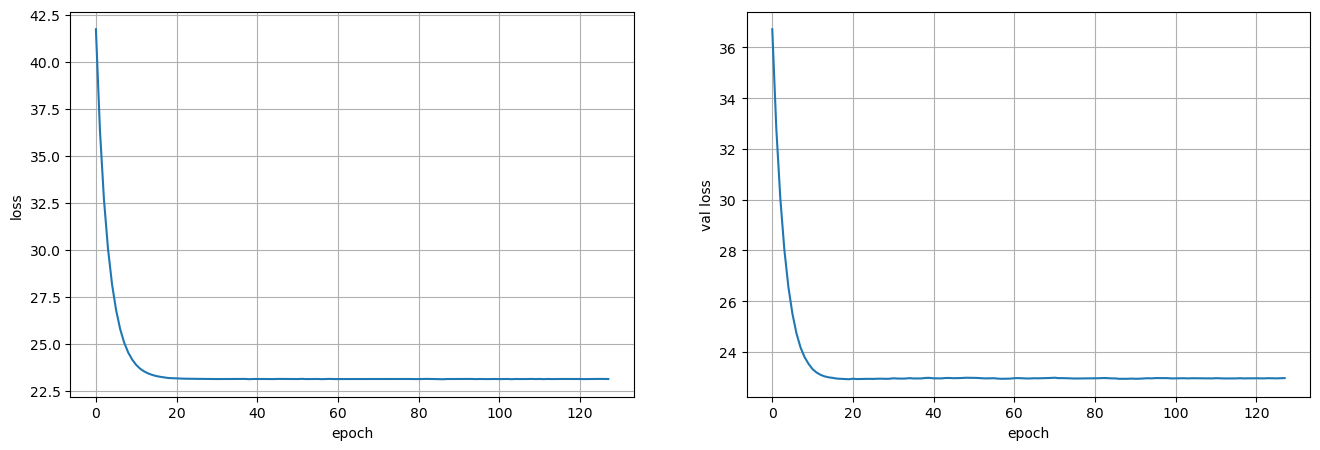

In [56]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

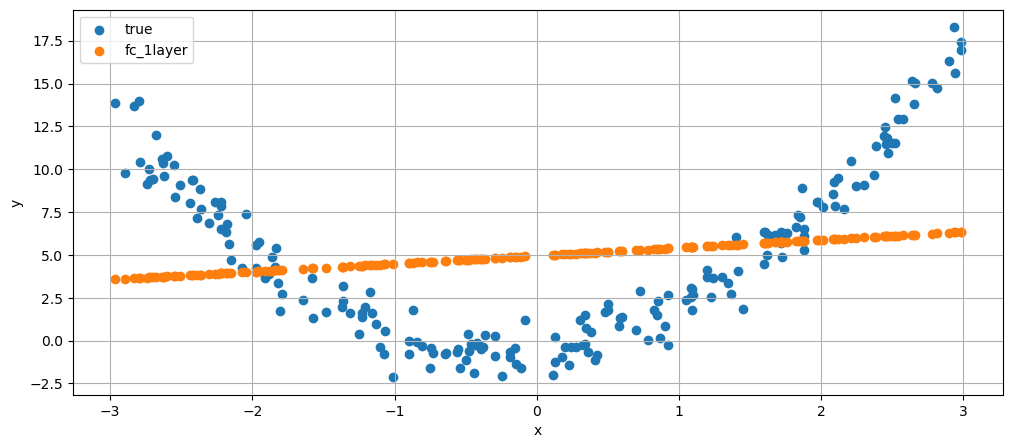

In [57]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_1layer")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [58]:
fc_1layer_train_losses = losses
fc_1layer_val_losses = val_losses
fc_1layer_preds = preds

### 2.2. Stack more layers

In [59]:
from torch.nn import Sequential
from torch.nn import ReLU

**Задание**: соберите сеть из двух полносвязных слоев размерами (1, 4) и (4, 1); добавьте между слоями нелинейность ReLU.

In [60]:
class MegaModel(torch.nn.Module):

    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()

        self.net = torch.nn.Sequential(
            CustomLinear(in_dim, hidden_dim),
            ReLU(),
            CustomLinear(hidden_dim, out_dim)
        )

    def forward(self, x): # model(x) -> out of model
        return self.net(x)

# YOUR CODE HERE

# one object (feature size 1) -> feature size 4 -> out of size 1

model = MegaModel(1, 4, 1)
# END OF YOUR CODE


In [66]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.6253],
        [-1.0011],
        [-0.1818],
        [-1.0152]], requires_grad=True)
Parameter containing:
tensor([-0.3238, -0.9287,  1.4789,  0.2069], requires_grad=True)
Parameter containing:
tensor([[ 0.2305,  2.0278, -0.6588, -1.6457]], requires_grad=True)
Parameter containing:
tensor([-0.3325], requires_grad=True)


In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [68]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)
    
    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:06<00:00, 20.67it/s]


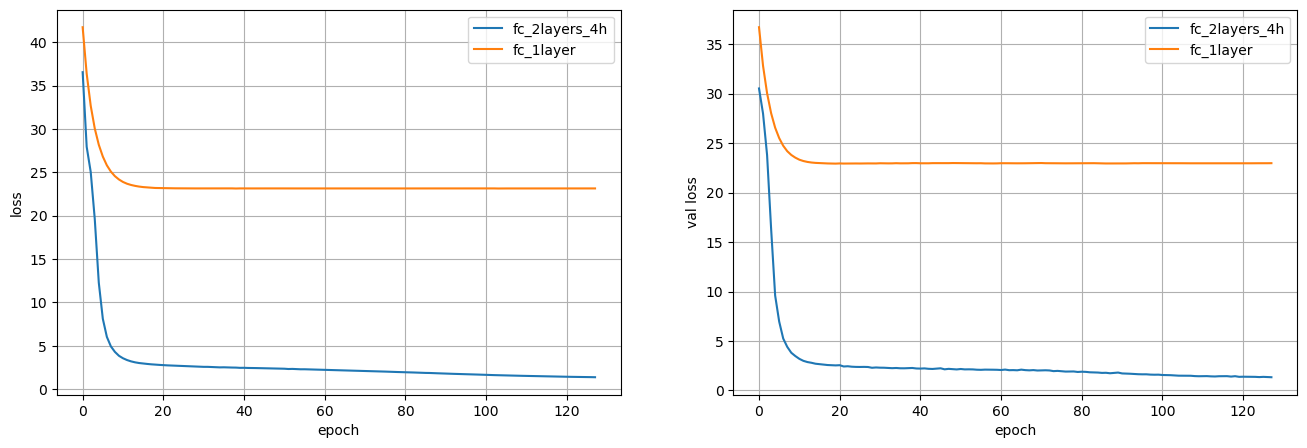

In [69]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="fc_2layers_4h")
plt.plot(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="fc_2layers_4h")
plt.plot(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

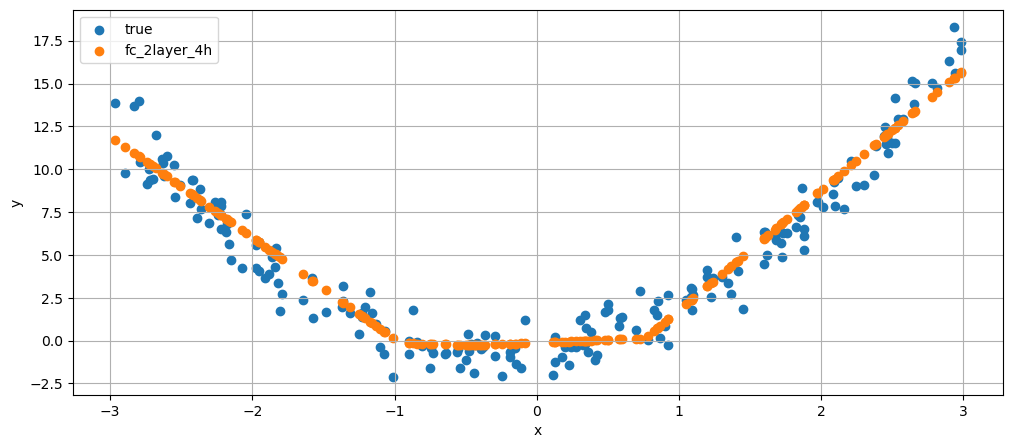

In [70]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_2layer_4h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [71]:
fc_2layer_4h_train_losses = losses
fc_2layer_4h_val_losses = val_losses
fc_2layer_4h_preds = preds

Добавим нейронов в скрытый слой:

In [72]:

model = MegaModel(1, 8, 1)
model

MegaModel(
  (net): Sequential(
    (0): CustomLinear(1, 8, bias=True)
    (1): ReLU()
    (2): CustomLinear(8, 1, bias=True)
  )
)

In [73]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [74]:
losses = []
val_losses = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)
    
    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

100%|██████████| 128/128 [00:06<00:00, 20.04it/s]


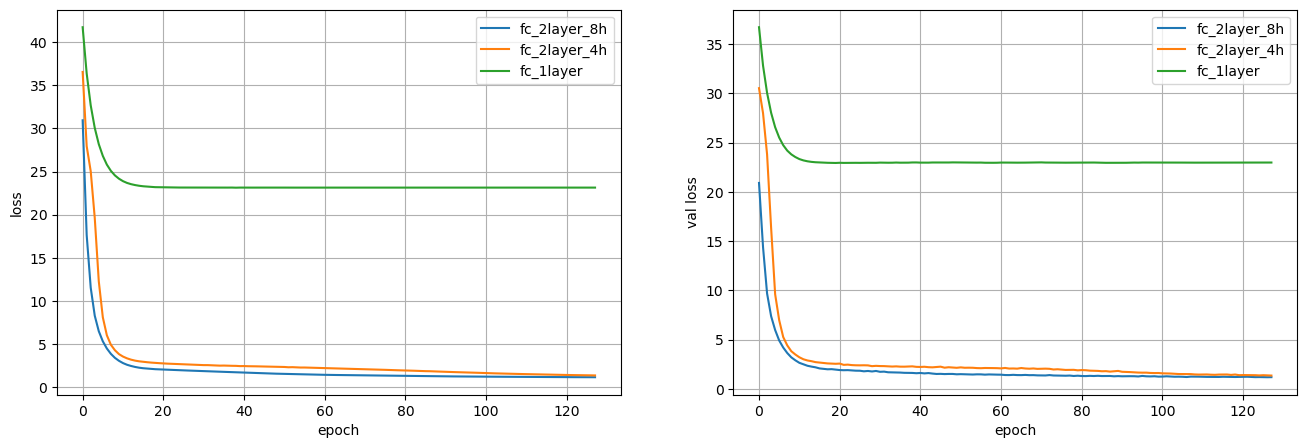

In [75]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="fc_2layer_8h")
plt.plot(fc_2layer_4h_train_losses, label="fc_2layer_4h")
plt.plot(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="fc_2layer_8h")
plt.plot(fc_2layer_4h_val_losses, label="fc_2layer_4h")
plt.plot(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

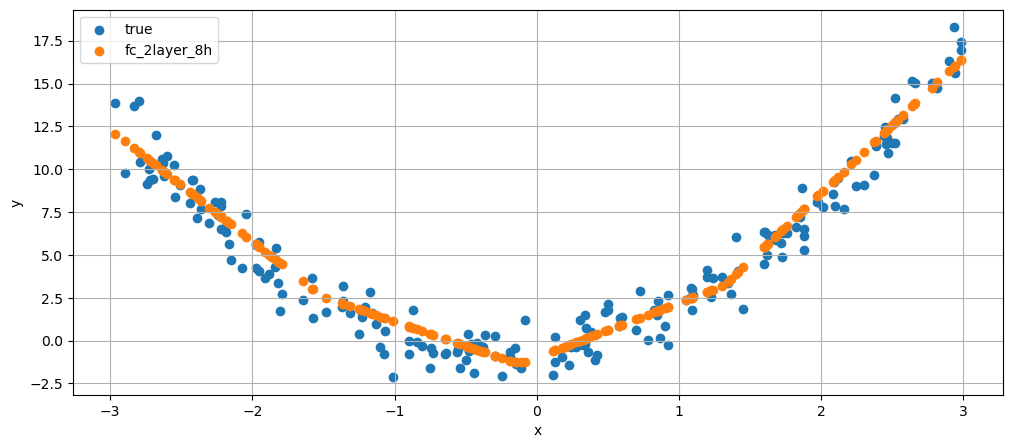

In [76]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], preds, label="fc_2layer_8h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Видимо, что наша модель ведет себя как кусочно-линейная функция. Любопытные визуализации на эту тему можно найти, например, [здесь](http://neuralnetworksanddeeplearning.com/chap4.htmlhttp://neuralnetworksanddeeplearning.com/chap4.html).

In [95]:
class MegaModel(torch.nn.Module):

    def __init__(self, in_dim, hidden_dim_list, out_dim):
        super().__init__()

        layers = []
        prev_dim = in_dim
        for hidden_dim in hidden_dim_list:
            layers.append(torch.nn.Linear(prev_dim, hidden_dim))
            layers.append(torch.nn.ReLU()) 
            prev_dim = hidden_dim

        layers.append(torch.nn.Linear(prev_dim, out_dim))

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x): # model(x) -> out of model
        return self.net(x)

model = MegaModel(1, [16, 16, 16], 1) # megaModel(in_dim, list of hidden dim [8, 8, 12], out dim)

In [96]:
x = torch.rand(4, 1)
out = model(x)

In [97]:
model

MegaModel(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [98]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 5.4801e-04],
        [ 9.6698e-01],
        [-7.6648e-01],
        [-6.9191e-01],
        [-6.1091e-01],
        [ 4.6178e-01],
        [-5.1559e-01],
        [ 6.5939e-01],
        [ 5.6829e-01],
        [ 8.7956e-01],
        [-3.0265e-01],
        [-1.6854e-01],
        [ 1.7407e-01],
        [ 3.0162e-01],
        [-9.7758e-01],
        [ 3.3896e-01]], requires_grad=True)
Parameter containing:
tensor([-0.4283, -0.0794,  0.5200, -0.2345, -0.8542, -0.4794,  0.2687,  0.9926,
        -0.7573,  0.2716, -0.7181, -0.0497, -0.0012, -0.3572, -0.8773,  0.6219],
       requires_grad=True)
Parameter containing:
tensor([[ 0.2474,  0.0326,  0.1320,  0.1610, -0.0644, -0.2059,  0.0612, -0.0912,
         -0.1241,  0.2332, -0.1196, -0.0543,  0.0557, -0.0703, -0.1817,  0.1915],
        [ 0.0055, -0.0575, -0.1651, -0.0708, -0.1795,  0.2087, -0.1119, -0.1337,
         -0.0252, -0.0239,  0.0104,  0.1407,  0.1395, -0.2085, -0.1707, -0.1292],
        [ 0.1650,  0.1523,  0.0

In [99]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

losses = []
val_losses = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)
    
    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

100%|██████████| 128/128 [00:10<00:00, 11.84it/s]


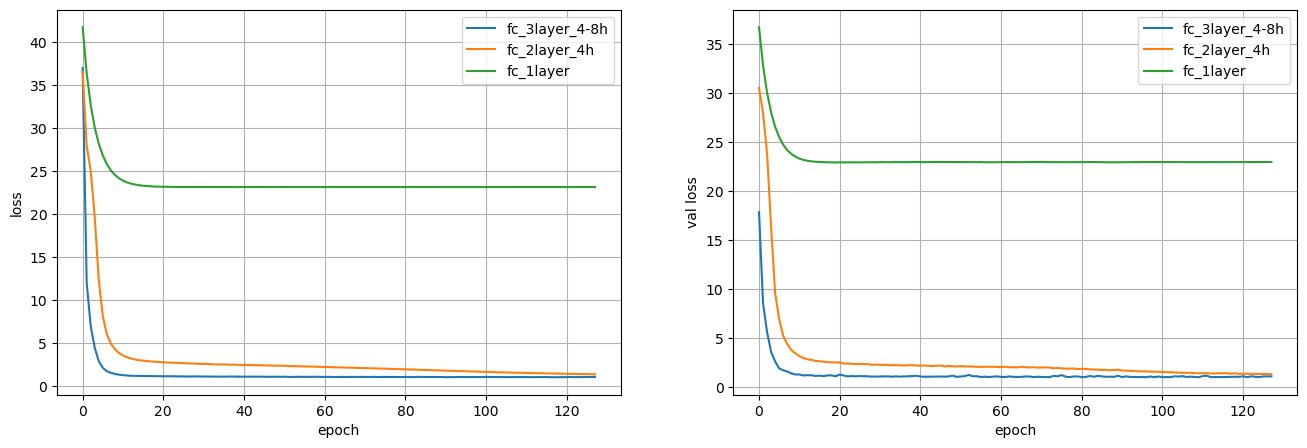

In [100]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="fc_3layer_4-8h")
plt.plot(fc_2layer_4h_train_losses, label="fc_2layer_4h")
plt.plot(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="fc_3layer_4-8h")
plt.plot(fc_2layer_4h_val_losses, label="fc_2layer_4h")
plt.plot(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

## 3. I/O

Обученные веса модели хорошо бы уметь сохранять и загружать для дальнейшего использования.

In [101]:
print(model)

MegaModel(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


В Pytorch сохранение и загрузка весов выполняется через `state_dict` модели:

In [102]:
print(model.state_dict())

OrderedDict([('net.0.weight', tensor([[ 5.4801e-04],
        [ 1.1604e+00],
        [-1.0363e+00],
        [-9.0891e-01],
        [-4.4200e-01],
        [ 3.6603e-01],
        [-6.7262e-01],
        [ 8.6757e-01],
        [ 8.6716e-01],
        [ 1.1648e+00],
        [-2.4612e-01],
        [-1.0256e-01],
        [ 2.1608e-01],
        [ 3.0798e-01],
        [-8.6829e-01],
        [ 2.1825e-01]])), ('net.0.bias', tensor([-0.4283, -0.4151,  0.2314, -0.6017, -1.0591, -0.5172,  0.0572,  0.7987,
        -0.8656, -0.1520, -0.7379, -0.0796, -0.1136, -0.3967, -1.0692,  1.0022])), ('net.2.weight', tensor([[ 2.4741e-01,  8.9446e-02,  3.9546e-01,  3.9914e-01,  1.4741e-01,
         -1.3784e-01,  2.3371e-01, -2.5442e-01, -2.3224e-02,  2.4104e-01,
         -1.1369e-01, -1.4277e-02,  6.7706e-02, -2.2399e-02,  1.2338e-01,
          3.9739e-02],
        [ 5.4526e-03, -5.7467e-02, -1.6508e-01, -7.0822e-02, -1.7953e-01,
          2.0872e-01, -1.1191e-01, -1.3370e-01, -2.5181e-02, -2.3943e-02,
          1

### 3.1. Save

In [103]:
output_fn = "./state_dict.pth.tar"

In [104]:
with open(output_fn, "wb") as fp:
    torch.save(model.state_dict(), fp)

### 3.2. Load

In [105]:
model = MegaModel(1,[16,16,16],1)

In [ ]:
print(model.state_dict())

In [106]:
with open(output_fn, "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
state_dict

OrderedDict([('net.0.weight',
              tensor([[ 5.4801e-04],
                      [ 1.1604e+00],
                      [-1.0363e+00],
                      [-9.0891e-01],
                      [-4.4200e-01],
                      [ 3.6603e-01],
                      [-6.7262e-01],
                      [ 8.6757e-01],
                      [ 8.6716e-01],
                      [ 1.1648e+00],
                      [-2.4612e-01],
                      [-1.0256e-01],
                      [ 2.1608e-01],
                      [ 3.0798e-01],
                      [-8.6829e-01],
                      [ 2.1825e-01]])),
             ('net.0.bias',
              tensor([-0.4283, -0.4151,  0.2314, -0.6017, -1.0591, -0.5172,  0.0572,  0.7987,
                      -0.8656, -0.1520, -0.7379, -0.0796, -0.1136, -0.3967, -1.0692,  1.0022])),
             ('net.2.weight',
              tensor([[ 2.4741e-01,  8.9446e-02,  3.9546e-01,  3.9914e-01,  1.4741e-01,
                       -1.3784e-01,  2

In [107]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [108]:
model.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 5.4801e-04],
                      [ 1.1604e+00],
                      [-1.0363e+00],
                      [-9.0891e-01],
                      [-4.4200e-01],
                      [ 3.6603e-01],
                      [-6.7262e-01],
                      [ 8.6757e-01],
                      [ 8.6716e-01],
                      [ 1.1648e+00],
                      [-2.4612e-01],
                      [-1.0256e-01],
                      [ 2.1608e-01],
                      [ 3.0798e-01],
                      [-8.6829e-01],
                      [ 2.1825e-01]])),
             ('net.0.bias',
              tensor([-0.4283, -0.4151,  0.2314, -0.6017, -1.0591, -0.5172,  0.0572,  0.7987,
                      -0.8656, -0.1520, -0.7379, -0.0796, -0.1136, -0.3967, -1.0692,  1.0022])),
             ('net.2.weight',
              tensor([[ 2.4741e-01,  8.9446e-02,  3.9546e-01,  3.9914e-01,  1.4741e-01,
                       -1.3784e-01,  2

Помимо непосредственно весов, бывает полезно сохранить и состояние других объектов: например, оптимизатора (чтобы продолжить обучении с той же точки):

In [ ]:
def save_checkpoint(model, optimizer, output_fn):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    
    with open(output_fn, "wb") as fp:
        torch.save(checkpoint, output_fn)
        
def load_checkpoint(checkpoint_fn, model, optimizer):
    with open(checkpoint_fn, "rb") as fp:
        checkpoint = torch.load(fp, map_location="cpu")
    
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer.param_groups[0]["lr"] = 1e-10
optimizer

In [ ]:
checkpoint_fn = "./checkpoint.pth.tar"

In [ ]:
save_checkpoint(model, optimizer, checkpoint_fn)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer

In [ ]:
load_checkpoint(checkpoint_fn, model, optimizer)

In [ ]:
optimizer